In [6]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import mean_absolute_error as mae
mse = nn.MSELoss()
import torch.optim.lr_scheduler as lr_scheduler
device=device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import seaborn as sns
from scipy.integrate import solve_ivp
import math

Euler Maruyama SDE Solver for Data Generation

In [2]:
def Euler_Maruyama(param,dt,n):
    [p1,p2] = param
    sol = np.zeros(n)
    sol[0] = 1
    for i in range(n-1):
        sol[i+1] = sol[i] +  p1*sol[i]*dt +  p2*sol[i]*np.random.randn(1)*np.sqrt(dt)
    return sol

Data Generation

0.06827936422043145
0.00101010101010101
(3500, 100)
(3500, 2)


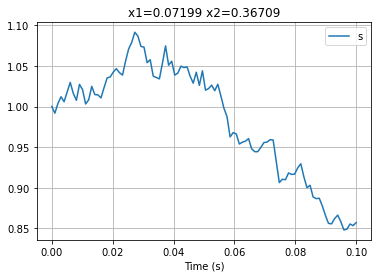

In [7]:
#Uniform random initialization of parameters x1 and x2 for 3500 data points
x1=np.random.uniform(0,0.1,3500)
x2=np.random.uniform(0,0.4,3500)
print(x1[2])

#Standard Deviation for x1 and x2
std_x1 = np.std(x1)
std_x2 = np.std(x2)

#Time discretization domain 
t = np.linspace(0,0.1,100)
dt = t[2]-t[1]
print(dt)

S=np.zeros([3500,100])
prm =np.zeros([3500,2]) 

for i in range(3500):
    z=np.random.randn(100)
    if i%50 == 0: # Each parameter has been replcated 50 times to produe 50 stochastic outputs
        p1 = x1[i]
        p2 = x2[i]
    param = [p1,p2]
    S[i,:]= Euler_Maruyama(param,dt,100)
    prm[i] = param
print(np.shape(S))
print(prm.shape)

#plot pdf
plt.figure(1)
plt.plot(t, S[10,:], label='s')
txt = "x1="+str(prm[10,0])[0:7]+" x2=" + str(prm[10,1])[0:7]
plt.title(label=txt)
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

[0.07199302 0.36709339]


<AxesSubplot:ylabel='Density'>

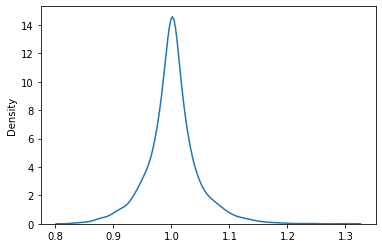

In [8]:
#Pdf of generated data at a particular time step
S_at_t = S[:,33]
print(prm[0])
sns.kdeplot(S_at_t)

In [5]:
#Preparing training dataset and dataloader

train_data = torch.from_numpy(S[0:2000,:]).to(device)
train_prm  = torch.from_numpy(prm[0:2000,:]).to(device)

Train_data = TensorDataset(train_data,train_prm)
Train_dl = DataLoader(Train_data, batch_size=50, shuffle=False) # We didn’t shuffle the data to club 


2000
torch.Size([1500, 100])


Deep Neural network

In [9]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        # Neural network that will fill in for drift term
        self.fp1 = nn.Sequential(nn.Linear(13,64),
                                nn.ELU(),
                                nn.Linear(64 ,256),
                                nn.ELU(),
                                nn.Linear(256,512),
                                nn.ELU(),
                                nn.Linear(512,256),
                                nn.ELU(),
                                nn.Linear(256, 64),
                                nn.ELU(),
                                nn.Linear(64,1))
        
        # Neural network that will fill in for diffusion term
        self.fA1 = nn.Sequential(nn.Linear(13, 64),
                                 nn.ELU(),
                                 nn.Linear(64 ,256),
                                 nn.ELU(),
                                 nn.Linear(256,512),
                                 nn.ELU(),
                                 nn.Linear(512,256),
                                 nn.ELU(),
                                 nn.Linear(256, 64),
                                 nn.ELU(),
                                 nn.Linear(64,1))
       


    def forward(self, batch_size, params,n):
        zp = params
        
        #Initializing the solution matrix
        s_dash = torch.zeros((batch_size,n),dtype = float).to(device) 
        
        #As the initial condition s_dash(@ t=0) = 1, assigning first column of s_dash as 1
        s_dash[:,0] = torch.ones((batch_size), dtype = float).to(device)
        
        #Loop for time marching
        for i in range(n-1):
            s = torch.reshape(s_dash[:,i],(batch_size,1))
            
            # Taking sample for Z(random variable) from standard gaussian distribution
            z_A1 = torch.randn(batch_size,10).to(device)
            
            #Taking out 1st column out from the parameters i.e x1 and calling it z_p0
            z_p0 = torch.reshape(zp[:,0],(batch_size,1))
            
            #Taking out 2nd column out from the parameters i.e x1 and calling it z_p1
            z_p1 = torch.reshape(zp[:,1],(batch_size,1))
            
            #Input to the Neural network that will replace drift part
            input_fp1 = torch.cat((z_A1,z_p1,z_p0,s),1).to(device)
            
            #Input to the Neural network that will replace diffusion part
            input_fA1 = torch.cat((z_A1,z_p1,z_p0,s),1).to(device)
            
            # Outputs from the two neural networks
            fA1_loc = self.fA1(input_fA1)
            fp1_loc = self.fp1(input_fp1)
            
            #Resize
            fA1_loc_ = torch.squeeze(fA1_loc)
            fp1_loc_ = torch.squeeze(fp1_loc)

            # Time as tensor  of size = batch size
            dT = dt * torch.ones(batch_size).to(device)
            
            # White noise as tensor of size = batch size
            dW = torch.randn(batch_size).to(device)
            
            # Using explicit Euler Maruyama to compute the output at (i+1)th step given the ith step soutput
            s_dash[:,i+1] = s_dash[:,i] + dT*fp1_loc_ + fA1_loc_*dW*torch.sqrt(dT)
           
        s_hat = s_dash
        
        return s_hat, zp

Loss Function

In [8]:
def gram_matrix(x, y, gamma1, pi1):
    sq_dist = torch.sum((torch.unsqueeze(x, 1)-torch.unsqueeze(y, 0))**2,2)  
    kernel = (pi1*torch.exp(-gamma1*sq_dist))
    return  kernel

In [9]:
def multidot(A,B,C,D):

  return torch.tensordot(A,torch.tensordot(B,torch.tensordot(C,D,dims=1),dims=1),dims=1)

In [11]:
def CMMD_loss(x_comp, x_hat, params, zp):
    
        #Mixture Coefficients 
        gamma1 = torch.sigmoid(lambda1)  
        pi1 = torch.exp(beta1).to(device)
        #Gram Matrices
        k_d = gram_matrix(params, params, gamma1, pi1)
        #print('k_d',k_d.shape)
        k_s = gram_matrix(zp, zp, gamma1, pi1)
        #print('k_s',k_s)
        l_d = gram_matrix(x_comp, x_comp, gamma1, pi1)
        #print('l_d',l_d)
        l_s = gram_matrix(x_hat, x_hat, gamma1, pi1)
        #print('l_s',l_s)
        k_sd = gram_matrix(params,zp, gamma1, pi1)
        #print('k_sd',k_sd)
        l_ds = gram_matrix(x_comp, x_hat, gamma1, pi1)
        #print('l_ds',l_ds)
        lam = 2.0 #hyperparameteR
        row, col = k_d.shape
        k_d_tilda = k_d + (lam*torch.eye(row,col,device="cuda"))
        #print( 'k_d_tild',k_d_tilda)
        k_s_tilda = k_s + (lam*torch.eye(row,col,device="cuda"))
        #print(' k_s_tilda',k_s_tilda)
        k_sd_tilda = k_sd + (lam*torch.eye(row,col,device="cuda"))
        #print('k_sd_tilda',k_sd_tilda)
        loss = torch.sqrt(torch.trace(multidot(k_d,torch.inverse(k_d_tilda),l_d,torch.inverse(k_d_tilda))) + torch.trace(multidot(k_s,torch.inverse(k_s_tilda),l_s,torch.inverse(k_s_tilda))) - 2*torch.trace(multidot(k_sd,torch.inverse(k_d_tilda),l_ds,torch.inverse(k_s_tilda))))
        #print('shape',loss.shape)
        return loss 

Training with MSE error as the loss function

In [11]:
def train(autoencoder, epochs):
    opt = torch.optim.Adam(autoencoder.parameters(),lr = .001)
    train_loss_epochs = torch.empty((epochs)).to(device)
    scheduler = lr_scheduler.StepLR(opt, step_size=500, gamma=0.9, verbose = True)
    for epoch in range(epochs):
        print(epoch)
        a=1
        b=1
        i=0
        train_cum_loss = 0
        for batch,params in Train_dl:
            s = batch  
            batch_size = s.shape[0]
            x1 = params[:,0] # since params is taking new set of values every iterations 
            x2 =  params[:,1]
            opt.zero_grad()
            s_hat,zp = autoencoder(s, x1=x1, x2=x2, batch_size=batch_size)
            i=+1
            loss_rec = ((s - s_hat)**2).sum()
            loss_kl =  autoencoder.encoder.kl
            loss = ((s - s_hat)**2).sum() + autoencoder.encoder.kl 
            train_cum_loss+=loss
            loss.backward()
            opt.step()
        scheduler.step()
        print("loss_rec",loss_rec)
        print("loss_kl",loss_kl)
        train_loss_epochs[epoch] = train_cum_loss/2000 #bATCH_SIZE
    return autoencoder, train_loss_epochs,opt

Training with CMMD as loss function

In [12]:
def train_CMMD(autoencoder, epochs):
    opt = torch.optim.Adam(autoencoder.parameters(),lr = .00001)
    train_loss_epochs = torch.empty((epochs)).to(device)
    scheduler = lr_scheduler.StepLR(opt, step_size = 500, gamma=0.9, verbose = True)
    for epoch in range(epochs):
        print(epoch)
        a=1
        b=1
        c=10
        i=0
        train_cum_loss = 0
        for batch,params in Train_dl:
           s = batch
           params = params[:,0:2]
           batch_size = s.shape[0]
           x1 = params[:,0] # since params is taking new set of values every iterations 
           #print("omega",omega.shape)
           x2 =  params[:,1]
           opt.zero_grad()
           s_hat,zp = autoencoder(batch_size=batch_size, params = params, n=100)
           i=+1
           loss_CMMD = CMMD_loss(s, s_hat, params, params)
           loss_rec = ((s - s_hat)**2).sum()
           loss = a*loss_CMMD 
           train_cum_loss+=loss
           loss.backward()
           opt.step()
        scheduler.step()
        train_loss_epochs[epoch] = train_cum_loss/2000 #bATCH_SIZE
        print("loss_CMMD",loss_CMMD)
        print("loss_rec",loss_rec)
    return autoencoder, train_loss_epochs, opt

Testing by generating random parameters

In [13]:
def test(autoencoder,n):
    x1=np.random.uniform(0,0.1,1500)
    x2=np.random.uniform(0,0.4,1500)
    t = np.linspace(0,0.1,100)
    dt = .001
    S=np.zeros([1500,n])
    prm_test =np.zeros([1500,2]) 
    for i in range(1500):
        q1 = x1[i]
        q2 = x2[i]
        param = [q1,q2]
        S[i,:]= Euler_Maruyama(param,dt,n)
        prm_test[i] = param
    print(S.shape)
    print(prm_test.shape)
    test_data1 = torch.from_numpy(S).to(device) 
    test_prm1 = torch.from_numpy(prm_test).to(device)
    Test_data1 = TensorDataset(test_data1,test_prm1)
    Test_dl_1 = DataLoader(Test_data1, batch_size=50, shuffle=False)
    with torch.no_grad():  
        s_full =  torch.empty(1500,n)
        s_hat_full =  torch.empty(1500,n)
        parameters =  torch.empty(1500,2) 
        i=0
        for batch,p in Test_dl_1:
            s = batch
            #print("s_shape",s.shape)
            batch_size = s.shape[0]
            parameters[i*batch_size:(i+1)*batch_size,:] = p
            #print(batch_size)
            s_full[i*batch_size:(i+1)*batch_size,:] = s
            s_hat,zp = autoencoder(batch_size=batch_size, params = p, n=n)
            s_hat_full[i*batch_size:(i+1)*batch_size,:] = s_hat
            i+=1
        x_hat = s_hat_full.cpu()
        X_hat = x_hat.detach().numpy()
        x = s_full.cpu()
        X= x.detach().numpy()
        er = mae = np.absolute(np.subtract(X_hat, X)).mean() 

    return er,parameters,X_hat,X

MAIN

Adjusting learning rate of group 0 to 1.0000e-05.
0
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0716, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(6.2406, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
1
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0644, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(6.8746, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
2
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0700, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(7.4492, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
3
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0834, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(12.1133, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
4
Adjusting learning rate of group 0 to 1.0000e-0

Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0524, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(9.9048, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
37
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0539, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(7.8700, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
38
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0728, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(7.2500, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
39
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0423, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(7.1239, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
40
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0601, device='cuda:0', dtyp

Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0476, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(5.6751, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
74
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0222, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(5.2959, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
75
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0591, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.9988, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
76
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0368, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(5.6374, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
77
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0185, device='cuda:0', dtyp

Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0205, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.4070, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
111
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0141, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.9376, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
112
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0159, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.5256, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
113
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0194, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(3.9184, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
114
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0096, device='cuda:0', 

Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0279, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.9271, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
148
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0142, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(5.2180, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
149
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0260, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.0763, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
150
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0521, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(3.8058, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
151
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0422, device='cuda:0', 

Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0522, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.9960, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
185
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0442, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.6484, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
186
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0633, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(5.2048, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
187
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0132, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)
loss_rec tensor(4.1992, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)
188
Adjusting learning rate of group 0 to 1.0000e-05.
loss_CMMD tensor(0.0164, device='cuda:0', 

Text(0, 0.5, 'Training loss')

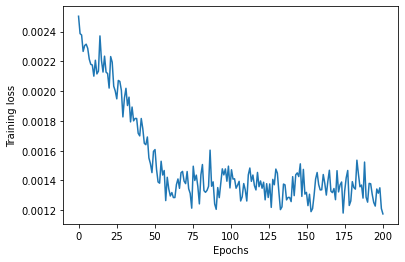

In [14]:
# No of epochs for training
epochs = 200

# lambda1 and beta1 are the parameters in the kernel function used to define the CMMD loss function
lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
beta1 = torch.tensor(4.0, requires_grad = True).to(device)

#Included in the training process
lambda1 = torch.nn.Parameter(lambda1)
beta1 = torch.nn.Parameter(beta1)

#Calling the DNN class and registering lambda1 and beta1 as learnable parameters
model = DNN().to(device)
model.register_parameter('lanbda11',lambda1)
model.register_parameter('beta1',beta1)

#Training
model,train_loss_epochs,opt= train_CMMD(model.double(),epochs)

#plotting training loss vs number of epochs at the end of the training
epochs_array = np.linspace(0,epochs,epochs)
train_loss_epochs= train_loss_epochs.cpu()
train_loss_epochs= train_loss_epochs.detach().numpy()
fig1=plt.figure(1)
plt.plot(epochs_array ,train_loss_epochs, label="training_loss")
plt.xlabel("Epochs")
plt.ylabel("Training loss")

In [15]:
#Saving the traind model
torch.save(model.state_dict(), 'PIDecoder_blackscholes_2k_Pboth')

Prediction and plotting

(1500, 300)
(1500, 2)
(1500, 300)


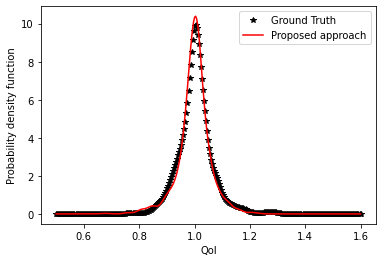

In [17]:
with torch.no_grad():  
    device = torch.device("cuda")
    
    # lambda1 and beta1 are the parameters in the kernel function used to define the CMMD loss function
    lambda1 = torch.tensor(-0.5, requires_grad = True).to(device)
    beta1 = torch.tensor(4.0, requires_grad = True).to(device)
    lambda1 = torch.nn.Parameter(lambda1)
    beta1 = torch.nn.Parameter(beta1)
    
    #Calling the DNN class and registering lambda1 and beta1 as learnable parameters
    model = DNN().to(device)
    model.register_parameter('lanbda11',lambda1)
    model.register_parameter('beta1',beta1)
    model.load_state_dict(torch.load('PIDecoder_blackscholes_2k_Pboth'))
    model.to(device)
    
    # Prediction upto nt number of time steps
    nt =1000
    mae,prm,X_hat,X=test(model.double(),nt)
    prm = prm.cpu()
    prm = prm.detach().numpy()
    Y_at_t = X[:,260]
    print(X_hat.shape)
    Y_hat_at_t = X_hat[:,260]

    #Plotting the prictions (Within the training window)
    x = np.linspace(0.5,1.6,300)
    from scipy.stats import gaussian_kde
    density = gaussian_kde(X[:,68])
    density_1 = gaussian_kde(X_hat[:,68] )
    density_p = gaussian_kde(X[:,260])
    density_p_1 = gaussian_kde(X_hat[:,260] )
    plt.figure(1)
    plt.plot(x,density(x),"*", color = "k",label = "Ground Truth")
    plt.plot(x,density_1(x),"r",label = "Proposed approach")
    plt.ylabel('Probability density function')
    plt.xlabel('QoI') 
    plt.legend()
    plt.savefig('PI_BS_Pboth.pdf')

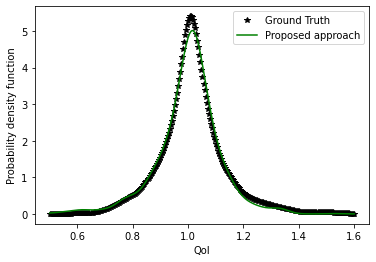

In [19]:
 #Plotting the prictions (Outside the training window)
plt.figure(2)
plt.plot(x,density_p(x),"*", color = "k",label = "Ground Truth")
plt.plot(x,density_p_1(x),"g",label = "Proposed approach")
plt.ylabel('Probability density function')
plt.xlabel('QoI') 
plt.legend()
plt.savefig('PI_BS_Pboth_pred.pdf')